## pip

In [1]:
!pip install datasets

In [ ]:
!pip install tiktoken

## Import

In [2]:
import os
import re
import time
import json
import random
import string
import psutil
import pickle
from tqdm import tqdm
from pprint import pprint
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers, decoders, processors
import tiktoken

import torch
from torch.utils.data import TensorDataset, Dataset, IterableDataset, DataLoader

In [3]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

# 🔴 **Utils**

In [4]:
def prepare_data(tokens, seq_len):
    # Trim tokens so that total length is divisible by seq_len
    n_tokens = (tokens.shape[0] // seq_len) * seq_len
    tokens = tokens[:n_tokens]

    # Reshape to 2D tensor
    return tokens.view(-1, seq_len)


In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [6]:
def calculate_time(model, x, num_runs=10):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(num_runs):
        model(*x)
    torch.cuda.synchronize()
    return (time.time() - start) / num_runs


def calculate_time_cpu(model, x, num_runs=10):
    start = time.time()
    for _ in range(num_runs):
        model(*x)
    return (time.time() - start) / num_runs

# 🟥 tokenize Tiktoken fast

In [ ]:
dataset=load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset.shape

{'train': (2119719, 1), 'validation': (21990, 1)}

In [ ]:
tokenizer=tiktoken.get_encoding("gpt2")
tokenized_train_samples = []
for item in tqdm(dataset["train"], desc="Tokenizing Train Set"):
    input_ids = tokenizer.encode(item["text"])
    tokenized_train_samples.append(np.array(input_ids))

In [ ]:
tokenized_valid_samples = []
for item in tqdm(dataset["validation"], desc="Tokenizing validation Set"):
    input_ids = tokenizer.encode(item["text"])
    tokenized_valid_samples.append(np.array(input_ids))

In [ ]:
tokenized_valid_samples[:1]

In [ ]:
sumtoks=  sum(len(tok) for tok in tokenized_train_samples)
print(sumtoks)

# 🟥 Train Bpe Tokenizer and data loader

## 🟧 BPE Trainer

In [ ]:
# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="|<unk>|"))

# Use a pre-tokenizer to split text into words
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

# Initialize a BPE trainer
trainer = trainers.BpeTrainer(
    vocab_size=10_000,  # Set the vocabulary size
    special_tokens=["|<unk>|", "<|endoftext|>"],
    min_frequency=2,  # Set the minimum frequency of tokens
    )

# Train the tokenizer on a custom dataset
tokenizer.train_from_iterator(dataset["train"]["text"], trainer)

# Add special tokens
tokenizer.post_processor = processors.TemplateProcessing(
    single="<|endoftext|> $A",
    special_tokens=[("<|endoftext|>", tokenizer.token_to_id("<|endoftext|>"))],
)

# Add decoder
tokenizer.decoder = decoders.ByteLevel(add_prefix_space=False)

# Save the trained tokenizer
tokenizer.save("bpe-tokenizer_tinystories.json")

#
print(f"🎉 Tokenizer training complete!")
print(f"🔹 Vocabulary size: {tokenizer.get_vocab_size():,} tokens")

🎉 Tokenizer training complete!
🔹 Vocabulary size: 10,000 tokens


In [ ]:
# Initialize a BPE tokenizer
tokenizer = Tokenizer.from_file("bpe-tokenizer_tinystories.json")
print(f"🎉 Tokenizer training complete!")
print(f"🔹 Vocabulary size: {tokenizer.get_vocab_size():,} tokens")

🎉 Tokenizer training complete!
🔹 Vocabulary size: 10,000 tokens


In [ ]:
sent = 'They played together all day and became best friends.'
tokens = tokenizer.encode(sent)
print(tokens.ids)
print(tokens.tokens)

pprint(tokenizer.decode(tokens.ids))

[1, 546, 667, 462, 378, 252, 161, 1042, 725, 375, 15]
['<|endoftext|>', 'They', 'Ġplayed', 'Ġtogether', 'Ġall', 'Ġday', 'Ġand', 'Ġbecame', 'Ġbest', 'Ġfriends', '.']
'They played together all day and became best friends.'


## 🟧 Save and load Tokens with BPE tokenizer

In [ ]:
# Tokenization {train}
tokenized_train_samples = []
for item in tqdm(dataset["train"], desc="Tokenizing Train Set"):
    input_ids = tokenizer.encode(item["text"]).ids
    tokenized_train_samples.append(np.array(input_ids))

Tokenizing Train Set: 100%|██████████| 2119719/2119719 [20:22<00:00, 1733.38it/s]


In [ ]:
tokenized_train_samples_concat=[]
tokenized_train_samples_concat = np.concatenate(tokenized_train_samples)
len(tokenized_train_samples_concat)

464965814

In [ ]:
# Save tokens as a pytorch file
torch.save(torch.tensor(tokenized_train_samples_concat), 'tokenized-train-samples_vocab-10k.pt')

In [ ]:
# Tokenization {validation}
tokenized_valid_samples = []
for item in tqdm(dataset["validation"], desc="Tokenizing Validation Set"):
    input_ids = tokenizer.encode(item["text"]).ids
    tokenized_valid_samples.append(np.array(input_ids))

Tokenizing Validation Set: 100%|██████████| 21990/21990 [00:12<00:00, 1822.45it/s]


In [ ]:
tokenized_valid_samples_concat=[]
tokenized_valid_samples_concat = np.concatenate(tokenized_valid_samples)
len(tokenized_valid_samples_concat)

4673588

In [ ]:
# Save tokens as a pytorch file
torch.save(torch.tensor(tokenized_valid_samples_concat), 'tokenized-valid-samples_vocab-10k.pt')

## 🟧 Custom dataset

In [11]:
class TinyStoriesDataset(Dataset):

    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = prepare_data(data, seq_len+1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample[:-1], sample[1:]

In [ ]:
train_set = TinyStoriesDataset(tokenized_train_samples, 128)
train_set.data.shape, len(train_set), train_set[0]

In [35]:
%timeit next(iter(train_set))

6.61 µs ± 192 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
b=next(iter(train_set))

In [ ]:
len(b)

## 🟧 DataLoader

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
tokenizer = Tokenizer.from_file("/content/drive/MyDrive/temp/bpe-tokenizer_tinystories.json")
tokenizer

Tokenizer(version="1.0", truncation=None, padding=None, added_tokens=[{"id":0, "content":"|<unk>|", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":1, "content":"<|endoftext|>", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}], normalizer=None, pre_tokenizer=ByteLevel(add_prefix_space=False, trim_offsets=True, use_regex=True), post_processor=TemplateProcessing(single=[SpecialToken(id="<|endoftext|>", type_id=0), Sequence(id=A, type_id=0)], pair=[Sequence(id=A, type_id=0), Sequence(id=B, type_id=1)], special_tokens={"<|endoftext|>":SpecialToken(id="<|endoftext|>", ids=[1], tokens=["<|endoftext|>"])}), decoder=ByteLevel(add_prefix_space=True, trim_offsets=True, use_regex=True), model=BPE(dropout=None, unk_token="|<unk>|", continuing_subword_prefix=None, end_of_word_suffix=None, fuse_unk=False, byte_fallback=False, ignore_merges=False, vocab={"|<unk>|":0, "<|endoftext|>":1, "!":2, """:3, "#":4, "$":5,

In [12]:
# tokenized_train_samples = torch.load('/content/drive/MyDrive/temp/tokenized-train-samples_vocab-10k.pt')
tokenized_valid_samples = torch.load('/content/drive/MyDrive/temp/tokenized-valid-samples_vocab-10k.pt')

# train_set = TinyStoriesDataset(tokenized_train_samples, seq_len=128)
valid_set = TinyStoriesDataset(tokenized_valid_samples, seq_len=128)

In [13]:
# train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True) #, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, pin_memory=True) #, num_workers=2)

In [14]:
x_batch, y_batch = next(iter(valid_loader))
x_batch.shape, y_batch.shape

(torch.Size([32, 128]), torch.Size([32, 128]))

In [ ]:
print(x_batch[0,:])
print('\n',y_batch[0,:])

In [ ]:
len(train_loader), len(valid_loader)

In [57]:
len(train_loader) / (20*60)

93.865

In [18]:
train_iter = iter(train_loader)

In [ ]:
%timeit next(train_iter)

## 🟧 EDA

In [ ]:
token_count_stories=[]
for tokns in tokenized_train_samples:
    token_count_stories.append(len(tokns))

In [ ]:
token_count_stories_np=np.array(token_count_stories)

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(token_count_stories, bins=50, kde=True)
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts')
plt.show()

In [ ]:
np.sort(token_count_stories_np)[:1000]

# 🟥 Transformer Model from scratch

In [ ]:
class MultiHeadAtention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv_proj = torch.nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = torch.nn.Linear(embed_dim, embed_dim)
    # احتمالا خطا ابعاد دارد زمان ترین ممکن است ترین نشود
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        k,q,v = self.qkv_proj(x).view(batch_size, seq_len, 3, self.num_heads, self.head_dim).transpose(1,2).chunk(3)
        # F.scaled_dot_product_attention(q,k,v)
        # return self.out_proj(x)
        return q

In [ ]:
x=torch.range(1,24).view(2,3,4)
print(x)

# /x=x.transpose(1,0)
print(x)
#

tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]],

        [[13., 14., 15., 16.],
         [17., 18., 19., 20.],
         [21., 22., 23., 24.]]])
tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]],

        [[13., 14., 15., 16.],
         [17., 18., 19., 20.],
         [21., 22., 23., 24.]]])


<ipython-input-35-bc631cf5fcde>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x=torch.range(1,24).view(2,3,4)


In [ ]:
print(x.shape)
y= MultiHeadAtention(4,2)(x)
y.shape

torch.Size([2, 3, 4])


ValueError: not enough values to unpack (expected 3, got 2)

# 🔴 **Model from scratch - Howsam**

## 🟠 Define

In [7]:
import time
from dataclasses import dataclass

from datasets import load_dataset
from tokenizers import Tokenizer

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 🟠 Embedding

In [17]:
wte = nn.Embedding(tokenizer.get_vocab_size(), 100)
wte(torch.tensor([1, 2,3])).shape

torch.Size([3, 100])

In [18]:
seq_len = 128
wpe = nn.Embedding(seq_len, 100)
wpe(torch.tensor([1, 2, 100])).shape

torch.Size([3, 100])

In [19]:
wpe(torch.arange(x_batch.shape[1])).shape

torch.Size([128, 100])

In [85]:
x = wte(x_batch) + wpe(torch.arange(x_batch.shape[1]))
x.shape

torch.Size([32, 128, 100])

## 🟠 Scaled Dot-Product Attention

In [21]:
q = k = v = x
print(q.shape)

mask = torch.tril(torch.ones(seq_len, seq_len))

scores = q @ k.transpose(-2, -1) / (k.shape[-1]**0.5)
scores.masked_fill_(mask ==0, float(-torch.inf))
scores = scores.softmax(dim=-1)
print(scores.shape)

z = scores @ v
z.shape

torch.Size([32, 128, 100])
torch.Size([32, 128, 128])


torch.Size([32, 128, 100])

In [ ]:
# scores = torch.randn(3, 5, 5)
# mask = torch.tril(torch.ones(5, 5))
# scores.masked_fill_(mask ==0, float(-torch.inf))
# scores = scores.softmax(dim=-1)
# scores

In [22]:
def scaled_dot_product_attention(q, k, v):
    mask = torch.tril(torch.ones(q.shape[-2], q.shape[-2])).to(device)
    scores = q @ k.transpose(-2, -1) / (k.shape[-1]**0.5)
    scores.masked_fill_(mask==0, float(-torch.inf))
    scores = scores.softmax(dim=-1)
    z = scores @ v
    return z

In [23]:
scaled_dot_product_attention(x.to(device), x.to(device), x.to(device)).shape

torch.Size([32, 128, 100])

In [24]:
q = torch.randn((128, 1024, 768), device=device)
k = torch.randn((128, 1024, 768), device=device)
v = torch.randn((128, 1024, 768), device=device)
q.shape

torch.Size([128, 1024, 768])

In [25]:
scaled_dot_product_attention(q, k, v).shape

torch.Size([128, 1024, 768])

In [27]:
# calculate_time(scaled_dot_product_attention, (q, k, v), num_runs=20)
calculate_time_cpu(scaled_dot_product_attention, (q, k, v), num_runs=20)

8.620952212810517

In [28]:
F.scaled_dot_product_attention(q, k, v, is_causal=True).shape

torch.Size([128, 1024, 768])

In [29]:
torch.abs(scaled_dot_product_attention(q, k, v) - F.scaled_dot_product_attention(q, k, v, is_causal=True)).max()

tensor(1.9073e-06)

In [ ]:
calculate_time(F.scaled_dot_product_attention, (q, k, v), num_runs=20)

## 🟠 Multi Head Attention

In [ ]:
# class MultiHeadAttention(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(100, 1000)
#         self.fc2 = nn.Linear(1000, 100)
#         self.fc3 = nn.Linear(1000, 100)

#     def forward(self, x):
#         y = F.relu(self.fc1(x))
#         y1 = self.fc2(y)
#         y2 = self.fc3(y)
#         return F.relu(torch.concat([y1, y2], dim=-1))

In [ ]:
# mha = MultiHeadAttention()
# num_trainable_params(mha)
# mha.forward(torch.rand(10, 100)).shape

In [83]:
# x=torch.randn(2,4)
# print(x)
# lx=nn.Linear(4,8,bias=False)
# y1 =x@ lx.weight.T
# y2=lx(x)
# print(y1.softmax(dim=-1).argmax(dim=0))
# print(y1.softmax(dim=-1))
# print(lx.weight.T.shape)

In [30]:
class GPTConfig:
    n_embd: int = 100
    n_head: int = 5

config = GPTConfig()
config.n_embd

100

In [93]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.head_size = self.n_embd // self.n_head

        self.qkv_proj = nn.Linear(self.n_embd, 3*self.n_embd, bias=False)

        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)
        self.c_proj.residual = True

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.qkv_proj(x).view(B, T, 3*self.n_head, self.head_size).transpose(1, 2).chunk(3, dim=-3)

        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.c_proj(y)
        return y ,q, k, v

In [94]:
mha = MultiHeadAttention(config)
y,q, k, v= mha(x)
print("X:",x.shape)
print("qkv_proj:",mha.qkv_proj.weight.T.shape)
print("c_proj:",mha.c_proj.weight.T.shape)

print("q:",q.shape)
print(k.shape)
print(v.shape)
print("y:",y.shape)
# mha(x).shape

X: torch.Size([32, 128, 100])
qkv_proj: torch.Size([100, 300])
c_proj: torch.Size([100, 100])
q: torch.Size([32, 5, 128, 20])
torch.Size([32, 5, 128, 20])
torch.Size([32, 5, 128, 20])
y: torch.Size([32, 128, 100])


In [ ]:
calculate_time(mha.to(device), (x.to(device),), num_runs=20)

0.0009491205215454102

## 🟠 Feed Forward (MLP)

In [95]:
class GPTConfig:
    n_embd: int = 100
    n_head: int = 5
    f_expnd: float = 4

config = GPTConfig()
config.n_embd

100

In [96]:
class FeedForward(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.f_expnd = config.f_expnd

        self.up_proj = nn.Linear(self.n_embd, int(self.f_expnd*self.n_embd), bias=False)
        self.down_proj = nn.Linear(int(self.f_expnd*self.n_embd), self.n_embd, bias=False)
        self.down_proj.residual = True

    def forward(self, x):
        return self.down_proj(F.gelu(self.up_proj(x)))

In [98]:
feedfor = FeedForward(config)
feedfor(x).shape

torch.Size([32, 128, 100])

In [99]:
num_trainable_params(feedfor)*1000

80.0

In [41]:
calculate_time(mlp, (x, ), num_runs=20)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## 🟠 Decoder Block

In [46]:
class DecoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd

        self.ln1 = nn.LayerNorm(config.n_embd)
        self.mha = MultiHeadAttention(config)

        self.ln2 = nn.LayerNorm(config.n_embd)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [47]:
decoder = DecoderBlock(config)
decoder(x).shape

torch.Size([32, 128, 100])

In [48]:
num_trainable_params(decoder) * 1e3

120.39999999999999

In [49]:
calculate_time_cpu(decoder, (x, ), num_runs=20) * 1e3

33.37346315383911

## 🟠 GPT

In [50]:
class GPTConfig:
    vocab_size: int = 10_000
    seq_len: int = 128
    n_layer: int = 12
    n_embd: int = 100
    n_head: int = 5
    f_expnd: float = 4


config = GPTConfig()
config.n_embd

100

In [52]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.seq_len, config.n_embd)
        # self.decoders = nn.Sequential(*[DecoderBlock(config) for _ in range(config.n_layer)])
        self.decoders = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)])
        self.lnf = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.lm_head.weight = self.wte.weight
        # self.lm_head.weight.data.uniform_(-1/self.lm_head.in_features**0.5, 1/self.lm_head.in_features**0.5)
        # nn.init.uniform_(self.lm_head.weight, -1/self.lm_head.in_features**0.5, 1/self.lm_head.in_features**0.5)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            if hasattr(module, 'residual'):
                std *= (2*self.config.n_layer)**-0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx):
        B, T = idx.shape

        x = self.wte(idx) + self.wpe(torch.arange(T, device=device))

        # x = self.decoders(x)
        for decoder in self.decoders:
            x = decoder(x)

        x = self.lnf(x)
        logits = self.lm_head(x)
        return logits

In [53]:
model = GPT(config).to(device)
model(x_batch.to(device)).shape

torch.Size([32, 128, 10000])

In [95]:
num_trainable_params(model), num_trainable_params(model.decoders), num_trainable_params(model.lm_head)

(2.4578, 1.4448, 1.0)

In [ ]:
calculate_time(model, (x_batch.to(device),), num_runs=100) * 1e3

13.62372875213623

## 🟠 Initialization

In [100]:
model = GPT(
    GPTConfig).to(device)

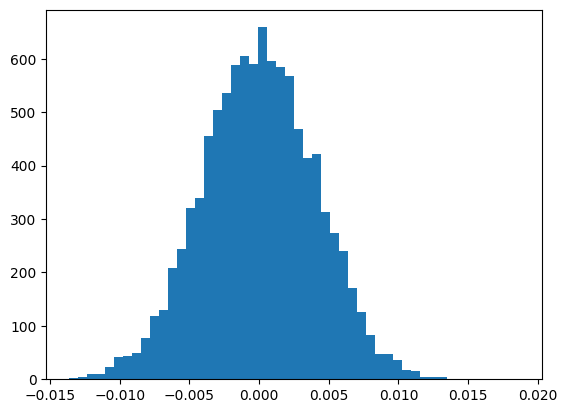

In [101]:
plt.hist(model.decoders[0].mha.c_proj.weight.flatten().detach().cpu(), bins=50);

In [ ]:
0.02 * (2*4)**-0.5 * 3

0.021213203435596427

In [ ]:
plt.hist(model.wpe.weight.flatten()[:100_000].detach().cpu(), bins=50);

In [ ]:
plt.hist(model)

In [ ]:
plt.hist(model.decoders[2].mlp.down_proj.weight.flatten().detach().cpu(), bins=50);

# 🟥 GPT model implement with nn.torch transformer